1. ODEs

    $$
    x' = u\\
    y' = v\\
    u' = v + (x-\mu) - \frac{(1-\mu)x}{\sqrt{x^2+y^2}^3} - \frac{\mu(x-1)}{\sqrt{(x-1)^2+y^2}^3}\\
    v' = -u + y - \frac{(1-\mu)y}{\sqrt{x^2+y^2}^3} - \frac{\mu y}{\sqrt{(x-1)^2+y^2}^3}
    $$

2. See `intersect_circle` [below](#Check-if-the-trajectory-intersect-with-a-circle)

3. Initial velocities

    $$
    \vec v(0) = \frac{\delta \vec x}{\delta t}
    $$

    See number (for the center value) [below](#Initial-velocity). Also see the [plot of 10 trajectories](#10-traces)

4. See [below](#100000-runs) for the result from $100000$ runs.

In [1]:
using PyPlot
using ODE
include("formatter.jl")

format_unc (generic function with 2 methods)

#### Check if the trajectory intersect with a circle

In [2]:
function intersect_circle(r1, r2, R, o=(0, 0))
    _x1, _y1 = r1
    _x2, _y2 = r2
    xo, yo = o
    x1 = _x1 - xo
    y1 = _y1 - yo
    x2 = _x2 - xo
    y2 = _y2 - yo
    r² = R^2
    r1² = x1^2 + y1^2
    r2² = x2^2 + y2^2
    if r1² <= r² || r2² <= r²
        return true
    end
    # Ax + By + C = 0
    A = y2 - y1
    B = x2 - x1
    C = x2 * y1 - x1 * y2
    A2B2 = A^2 + B^2
    xq = - A * C / A2B2
    yq = - B * C / A2B2
    if ((xq <= x1) $ (xq <= x2)) || ((yq <= y1) $ (yq <= y2))
        return xq^2 + yq^2 <= r²
    end
    return false
end

intersect_circle (generic function with 2 methods)

In [3]:
immutable DiffF{T}
    μ::T
end

function call(d::DiffF, t, y)
    x, y, u, v = y
    x′ = u
    y′ = v
    r0⁻³ = (x^2 + y^2)^(-3/2)
    r1⁻³ = ((x - 1)^2 + y^2)^(-3/2)
    u′ = v + (x - d.μ) - (1 - d.μ) * x * r0⁻³ - d.μ * (x - 1) * r1⁻³
    v′ = -u + y - (1 - d.μ) * y * r0⁻³ - d.μ * y * r1⁻³
    [x′, y′, u′, v′]
end

call (generic function with 1901 methods)

#### Initial velocity

In [4]:
x_002 = [1.0802, -0.0189]
x_0 = [1.0798, 0.0]
v_0 = (x_002 - x_0) ./ 0.02

2-element Array{Float64,1}:
  0.02 
 -0.945

In [5]:
function collect_traces(collector, x0, x1, δt0, ts0, δr, nrep)
    for i in 1:nrep
        x0′ = [x0[i] + rand(eltype(x0)) * 2δr - δr for i in 1:length(x0)]
        x1′ = [x1[i] + rand(eltype(x1)) * 2δr - δr for i in 1:length(x1)]
        v0 = (x1′ - x0′) ./ δt0
        ts, ys = ode78(DiffF(0.01), [x0′; v0], ts0)
        collector(ts, ys, x0′, x1′, v0)
    end
end

collect_traces (generic function with 1 method)

In [6]:
immutable PlotCollector
end
function call(::PlotCollector, ts, ys, x0, x1, v0)
    rxs = [ys[i][1] for i in 1:length(ys)]
    rys = [ys[i][2] for i in 1:length(ys)]
    plot(rxs, rys)
end

call (generic function with 1903 methods)

#### 10-traces

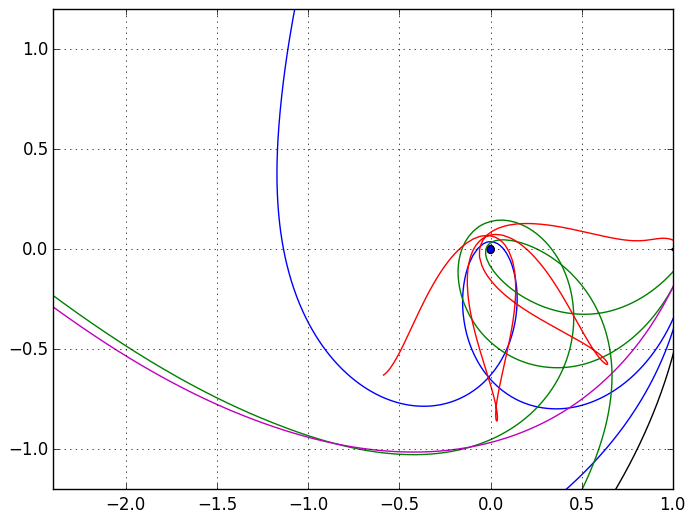

In [7]:
xlim([-2.4, 1.0])
ylim([-1.2, 1.2])
collect_traces(PlotCollector(), x_0, x_002, 0.02, linspace(0, 10, 1000), 0.002 * 6, 10)
ax = gca()
moon_circ = matplotlib[:pyplot][:Circle]((1, 0), 0.005)
earth_circ = matplotlib[:pyplot][:Circle]((0, 0), 0.02)
ax[:add_artist](moon_circ)
ax[:add_artist](earth_circ)
grid()

In [8]:
type CollisionCollector
    moon::Int
    earth::Int
    none::Int
    moon_trace
    earth_trace
    CollisionCollector() = new(0, 0, 0)
end
function call(c::CollisionCollector, ts, ys, x0, x1, v0)
    prev_r = ys[1][1], ys[1][2]
    @inbounds for i in 2:length(ys)
        # Assuming we don't have a segment that collide with both earth and the moon
        y = ys[i]
        r = y[1], y[2]
        if intersect_circle(prev_r, r, 0.02, (0.0, 0.0))
            c.earth += 1
            isdefined(c, :earth_trace) || (c.earth_trace = ys)
            return
        elseif intersect_circle(prev_r, r, 0.005, (1.0, 0.0))
            c.moon += 1
            isdefined(c, :moon_trace) || (c.moon_trace = ys)
            return
        end
        prev_r = r
    end
    c.none += 1
    return
end

call (generic function with 1905 methods)

#### 100000 runs

Moon: 5.306(72)%
Earth: 11.70(10)%
None: 82.99(28)%


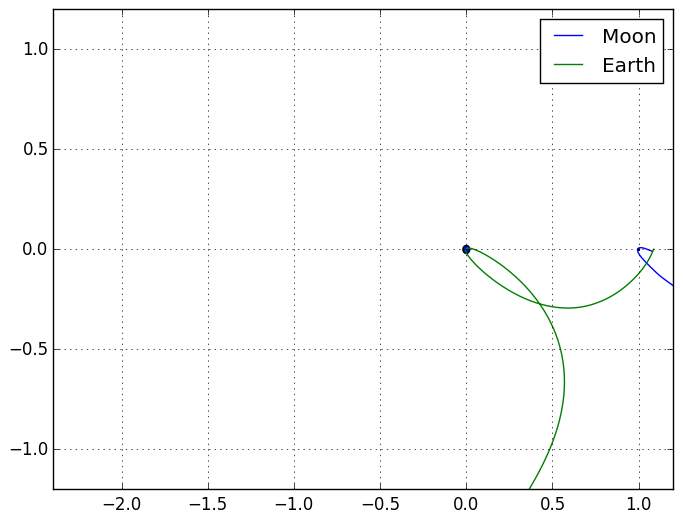

In [9]:
nrun = 100_000
collisions = CollisionCollector()
collect_traces(collisions, x_0, x_002, 0.02, linspace(0, 10, 1000), 0.002 * 6, nrun)
for (trace, name) in ((collisions.moon_trace, "Moon"),
                       (collisions.earth_trace, "Earth"))
    plot([trace[i][1] for i in 1:length(trace)],
         [trace[i][2] for i in 1:length(trace)], label=name)
end

xlim([-2.4, 1.2])
ylim([-1.2, 1.2])
legend()
ax = gca()
moon_circ = matplotlib[:pyplot][:Circle]((1, 0), 0.005)
earth_circ = matplotlib[:pyplot][:Circle]((0, 0), 0.02)
ax[:add_artist](moon_circ)
ax[:add_artist](earth_circ)
grid()
sleep(0.1)

p_moon = collisions.moon / nrun
p_earth = collisions.earth / nrun
p_none = collisions.none / nrun

# Assuming we have enough samples....
σ_moon = sqrt(collisions.moon) / nrun
σ_earth = sqrt(collisions.earth) / nrun
σ_none = sqrt(collisions.none) / nrun

println("Moon: $(format_unc(p_moon * 100, σ_moon * 100, unit="%"))")
println("Earth: $(format_unc(p_earth * 100, σ_earth * 100, unit="%"))")
println("None: $(format_unc(p_none * 100, σ_none * 100, unit="%"))")
sleep(0.1)